In [1]:
import monai
import monai.transforms
import SimpleITK as sitk
import numpy as np 
import torch

import rootutils
rootutils.setup_root(search_from="/work/hpc/spine-segmentation/notebooks/logger_wandb.ipynb", indicator="setup.py", pythonpath=True)
from src.data.transforms import array
import matplotlib.pyplot as plt

Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.


# Inverse Transforms

In [59]:
train_transform = monai.transforms.Compose([monai.transforms.LoadImaged(keys=["image", "label"], image_only = False),
                                        array.ConvertToMultiChannelBasedOnSpiderClassesdSemantic(keys=["label"]),
                                        monai.transforms.EnsureChannelFirstd(keys=["image"], channel_dim='no_channel'),
                                        monai.transforms.Spacingd(
                                            keys=["image", "label"],
                                            pixdim=(2.0, 2.0, 2.0),
                                            mode=("bilinear", "nearest"),
                                        ),
                                    #   monai.transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys=["label"]),
                                        monai.transforms.RandSpatialCropd(keys=["image", "label"], roi_size=[32, 128, 128], random_size=False),
                                        monai.transforms.Resized(keys=["image", "label"], spatial_size=(32, 420, 420)),
                                        monai.transforms.NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
                                        # monai.transforms.ToTensord(keys=["image", "label"]),])
                                        ])

In [60]:
val_transform = train_transform

In [61]:
data = val_transform({"image" :"/data/hpc/spine/dataset/spine_nii/images/10_t1.nii.gz",
                      "label": "/data/hpc/spine/dataset/spine_nii/masks/10_t1.nii.gz"})

In [62]:
data['image']

metatensor([[[[-0.9609, -0.9609, -0.9609,  ..., -0.8836, -0.8836, -0.8836],
          [-0.9609, -0.9609, -0.9609,  ..., -0.8836, -0.8836, -0.8836],
          [-0.9609, -0.9609, -0.9609,  ..., -0.8836, -0.8836, -0.8836],
          ...,
          [-0.9609, -0.9609, -0.9609,  ...,  0.3292,  0.3292,  0.3292],
          [-0.9609, -0.9609, -0.9609,  ...,  0.3292,  0.3292,  0.3292],
          [-0.9609, -0.9609, -0.9609,  ...,  0.3292,  0.3292,  0.3292]],

         [[-0.9609, -0.9609, -0.9609,  ..., -0.9182, -0.9182, -0.9182],
          [-0.9609, -0.9609, -0.9609,  ..., -0.9182, -0.9182, -0.9182],
          [-0.9609, -0.9609, -0.9609,  ..., -0.9182, -0.9182, -0.9182],
          ...,
          [-0.9609, -0.9609, -0.9609,  ...,  0.4715,  0.4715,  0.4715],
          [-0.9609, -0.9609, -0.9609,  ...,  0.4715,  0.4715,  0.4715],
          [-0.9609, -0.9609, -0.9609,  ...,  0.4715,  0.4715,  0.4715]],

         [[-0.9609, -0.9609, -0.9609,  ..., -0.9528, -0.9528, -0.9528],
          [-0.9609, -0.960

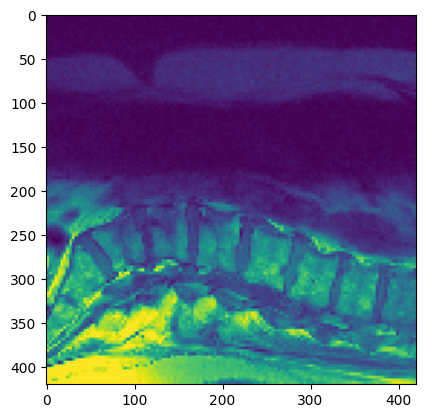

In [54]:
plt.imshow(data['image'][0, 12, :, :])

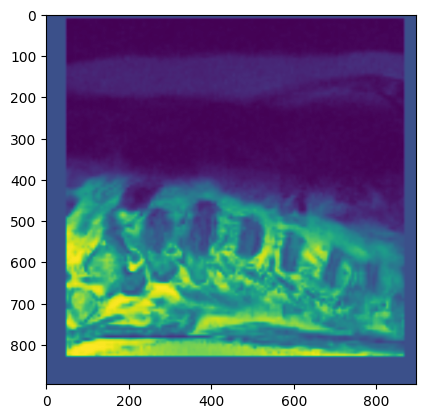

In [30]:
from monai.transforms.utils import allow_missing_keys_mode


with allow_missing_keys_mode(val_transform):
    inverse_data = val_transform.inverse({"image": data['image']})

plt.imshow(inverse_data["image"][0, 12])

# Batch Inverse

In [32]:
from typing import Optional, List
import monai
import monai.transforms
from monai.data import pad_list_data_collate

import SimpleITK as sitk
import numpy as np 
import torch
from lightning import LightningDataModule
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torchvision.transforms import transforms
import json
import os
import rootutils

rootutils.setup_root(search_from="/work/hpc/spine-segmentation/notebooks/logger_wandb.ipynb", indicator="setup.py", pythonpath=True)
from src.data.transforms import array

# always starting with vanilla dataset, like its a norm to me now
class SpiderDataset(Dataset):
    num_class = 15
    def __init__(self, 
                 data = None,
                 data_dir: str = "", 
                 json_path: str = "",
                 ):
        super().__init__()
        self.data = list()
        self.data_dir = data_dir
        if data is not None:
            self.data = data
        else:
            if data_dir == "" or json_path == "":
                raise AssertionError("No dataset ?")
            self.setup(json_path)
    
    def setup(self, json_path):
        json_object = json.load(open(json_path, "r"))
        keys = json_object.keys()
        if "training" in keys:
            for key in keys:
                self.data.extend(json_object[key])
        else:
            try:
                self.data.extend(json_object)
            except:
                raise InsertionError("Something wrong with json file, cannot load or do anything, at all")
    
    def get_item(self, index: int):
        output = dict()
        output["image"] = ""
        output["label"] = ""
        if isinstance(self.data[index]["image"], list):
            output["image"] = [os.path.join(self.data_dir, image) for image in self.data[index]["image"]]
        else:
            # Add for debugging
            path = os.path.join(self.data_dir, self.data[index]["image"])
            output["image"] = path ##Set to 4 because the model_inferr in validation_step
        output["label"] = os.path.join(self.data_dir, self.data[index]["label"])
        return output
    
    # In case they query in list of index
    def __getitem__(self, index):
        output = None
        if not isinstance(index, int):
            output = []
            for id in index:
                output.append(self.get_item(id))
        else:
            output = self.get_item(int(index))
        
        return output
    
    def __len__(self) -> int:
        return len(self.data)
    
    

class SpiderTransformedDataset(Dataset):
    def __init__(self, 
                 dataset: SpiderDataset,
                 transform: monai.transforms.Compose):
        super().__init__()
        self.dataset = dataset
        self.transform = transform
    
    def __getitem__(self, index):
        output = None
        
        if not isinstance(index, int):
            output = []
            for id in index:
                output.append(self.transform(self.dataset[id]))
        else:
            output = self.transform(self.dataset[int(index)])

        return output
    
    def __len__(self) -> int:
        return len(self.dataset)

In [78]:
train_transform = monai.transforms.Compose([monai.transforms.LoadImaged(keys=["image", "label"], image_only = False),
                                        array.ConvertToMultiChannelBasedOnSpiderClassesdSemantic(keys=["label"]),
                                        monai.transforms.EnsureChannelFirstd(keys=["image"], channel_dim='no_channel'),
                                        monai.transforms.Spacingd(
                                            keys=["image", "label"],
                                            pixdim=(2.0, 2.0, 2.0),
                                            mode=("bilinear", "nearest"),
                                        ),
                                    #   monai.transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys=["label"]),
                                        # monai.transforms.RandSpatialCropd(keys=["image", "label"], roi_size=[32, 128, 128], random_size=False),
                                        monai.transforms.Resized(keys=["image", "label"], spatial_size=(32, 420, 420)),
                                        monai.transforms.NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
                                        # monai.transforms.ToTensord(keys=["image", "label"]),])
                                        ])

val_transform = train_transform


dataset = SpiderDataset(data_dir = "/data/hpc/spine/dataset/spine_nii", json_path="/data/hpc/spine/jsons/test.json")
dataset = SpiderTransformedDataset(dataset, val_transform)

val_loader = DataLoader(dataset, batch_size = 2, num_workers = 2, collate_fn = pad_list_data_collate)


In [79]:
batch_inverter = monai.transforms.BatchInverseTransform(val_transform, val_loader)

for i, batch in enumerate(val_loader):
    print(i)
    print(batch["image"].shape)
    with allow_missing_keys_mode(val_transform):
        inverse_batch = batch_inverter({"image": batch['image']})
        print(inverse_batch[0]["image"])

0
torch.Size([2, 1, 32, 420, 420])
metatensor([[[[-0.5924, -0.5924, -0.5924,  ..., -0.5924, -0.5924, -0.5924],
          [-0.5924, -0.5924, -0.5924,  ..., -0.5924, -0.5924, -0.5924],
          [-0.5924, -0.5924, -0.5924,  ..., -0.5924, -0.5924, -0.5924],
          ...,
          [-0.5924, -0.5924, -0.5924,  ..., -0.5924, -0.5924, -0.5924],
          [-0.5924, -0.5924, -0.5924,  ..., -0.5924, -0.5924, -0.5924],
          [-0.5924, -0.5924, -0.5924,  ..., -0.5924, -0.5924, -0.5924]],

         [[-0.5924, -0.5924, -0.5924,  ..., -0.5924, -0.5924, -0.5924],
          [-0.5924, -0.5924, -0.5924,  ..., -0.5924, -0.5924, -0.5924],
          [-0.5924, -0.5924, -0.5924,  ..., -0.5924, -0.5924, -0.5924],
          ...,
          [-0.5924, -0.5924, -0.5924,  ..., -0.5924, -0.5924, -0.5924],
          [-0.5924, -0.5924, -0.5924,  ..., -0.5924, -0.5924, -0.5924],
          [-0.5924, -0.5924, -0.5924,  ..., -0.5924, -0.5924, -0.5924]],

         [[-0.5924, -0.5924, -0.5924,  ..., -0.5924, -0.5924, -

torch.Size([1, 15, 896, 896])
metatensor([[-0.9319, -0.9319, -0.9319,  ..., -0.9319, -0.9319, -0.9319],
        [-0.9319, -0.9319, -0.9319,  ..., -0.9319, -0.9319, -0.9319],
        [-0.9319, -0.9319, -0.9319,  ..., -0.9319, -0.9319, -0.9319],
        ...,
        [-0.9319, -0.9318, -0.9318,  ..., -0.9319, -0.9319, -0.9319],
        [-0.9319, -0.9318, -0.9318,  ..., -0.9319, -0.9319, -0.9319],
        [-0.9319, -0.9319, -0.9318,  ..., -0.9319, -0.9319, -0.9319]])


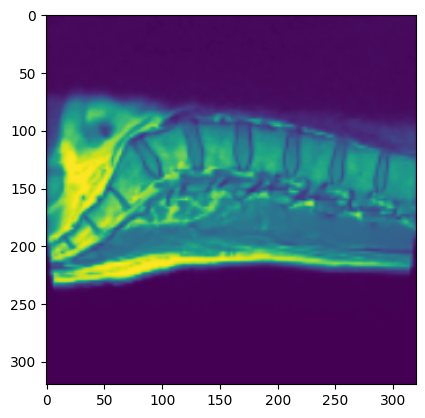

In [85]:
print(inverse_batch[0]["image"].shape)
print(inverse_batch[0]["image"][0, 10])
plt.imshow(inverse_batch[1]["image"][0, 10])